In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from pipeline_timing import pipeline_with_dataload
from profiling_util import average_profilings, sort_files, plot_profiling_params
from numpy import std
from segmentation.caiman_interface import extract_masks
from caiman import load_memmap
import numpy as np

Bokeh could not be loaded. Either it is not installed or you are not running within a notebook
numba not found


Using TensorFlow backend.


Load in files and set parameters needed for code that we will be timing

In [2]:
mmap_filename = 'segmentation/data/caiman/caiman_d1_240_d2_240_d3_1_order_C_frames_61717_.mmap'
mmap_scan, (image_height, image_width), num_frames = load_memmap(mmap_filename)
scan = np.array(mmap_scan)
scan = scan.reshape(image_height, image_width, num_frames, order='F')

In [3]:
params = {'num_background_components': 1,
 'merge_threshold': 0.7,
 'fps': 8.3091,
 'init_on_patches': True,
 'proportion_patch_overlap': 0.2,
 'num_components_per_patch': 6,
 'init_method': 'greedy_roi',
 'patch_size': [20.0, 20.0],
 'soma_diameter': [3.2, 3.2],
 'num_processes': 8,
 'num_pixels_per_process': 10000}

put function that you want to time in the lambda function. average times from {num_calls} function calls. Results will be saved in directory specified in the average_profilings function

In [4]:
num_calls = 5
#profile_function = lambda : pipeline_with_dataload('/mnt/at-export01/rotating_students/2024_01_01_Frank_DeGuire/raster_motion_miniscan_export01.pkl', num_processes=8)
profile_function = lambda : extract_masks(scan, mmap_scan, **params)
result, individual_times, last_output = average_profilings(profile_function, num_calls, f'data/average_profile_{num_calls}runs.prof')
print(f"Averaged {num_calls} function calls, at a time of {round(result.total_tt, 2)} seconds per call. Program run times had a standard deviation of {round(std(individual_times), 3)} seconds.")
print(f'Saved results in time_profiling_data/average_profile_{num_calls}runs.prof.')

/usr/local/lib/python3.6/dist-packages/caiman/source_extraction/cnmf/merging.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  C_corr[ii,overlap_indeces] = corr_values


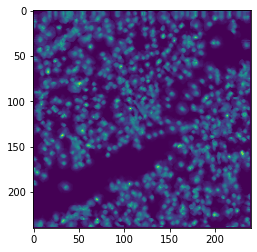

In [5]:
# verify output of function
import matplotlib.pyplot as plt
# spike_traces, AR_coeffs, masks, traces, background_masks, background_traces, raw_traces = last_output
masks, traces, background_masks, background_traces, raw_traces = last_output
plt.imshow(masks.sum(axis=-1))

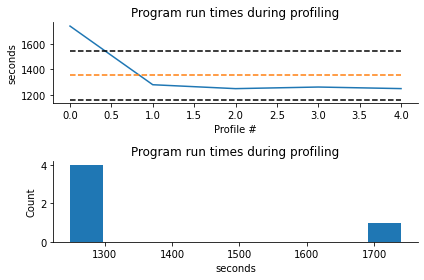

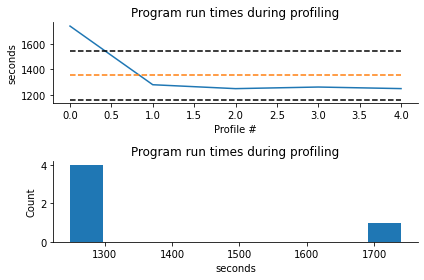

In [6]:
plot_profiling_params(individual_times, result.total_tt)

In [11]:
np.save('masks_old.npy', masks)

# Timing profiling usage:
    - Run "average_proflings" function above
    - Run "snakeviz time_profiling_data/average_profile_{num_calls}runs.prof" to visualize output in browser
    - If there are instances of multiple function call timings overlapping with each other, can call "tuna data/average_profile_{num_calls}runs.prof" to account for these inconsistencies
        - tuna also gives percentages of total run time for each function call
    - If using multiprocessing (such as in segmentation), may need to use viztracer: "viztracer --multi-processing pipeline_timing.py"
        - View results with "vizviewer --flamegraph result.json"

Memory profiling usage:
    - two libraries
        - memory_profiler: samples program periodically so you can track memory usage over course of program
            - "mprof run --python python pipeline_mprof.py"
            - "mprof plot --flame"
                - can get additional granularity into which functions are taking up memory by adding more @profile decorators in pipeline_profiling.py file
            - clean up files afterwards with "mprof clean"
            - can run all steps together with "python run_mprof.py"
            - can use "multiprocess" and "--include-children" flags for multiprocess programs
        - memray: provides memory size of largest objects at peak memory usage
            - "memray run pipeline_memray.py"
                - use "--follow-fork" tag for multiprocessing tracking
            - generate graph outlining largest memory allocations during peak memory usage: "memray flamegraph [output file name from run operator]"
            - open graph in browser: "open [flamegraph file name]"
            - also outputs interesting memory profiling statistics: "memray stats [output file name from run operator]"
            - can run all steps together with "python run_memray.py"
    - can clean up files afterwards by running cell below

To run any/all of the above:
    - in command line, run "python run_profiling.py [-m] [-p] [-t] [# of runs to average]
        - m runs memray, p runs mprof, and t runs the time profiling
        - note: may need to exit out of matplotlib plots to let program continue running (but files also get saved, so no need to worry)

Scaling concerns:
    - does cProfile work when running with multiple processors?
        - we will figure out later
        - viztracer definitely works, so may need to switch over to that
    - are memory profiling scripts too modularized?
        - having too many subfunctions may increase memory consumption
        - just keep skeleton of high level functions, similar to how script will be run in real usage
        - leave deep modularization to the timing script

## sort_files()

In [7]:
from pipeline import meso

In [8]:

meso


<module 'pipeline.meso' from '/usr/local/lib/python3.6/dist-packages/pipeline/meso.py'>